### 1.  Bessel functions

```python

import numpy as np
import numpy.testing as ntest
import doctest


def bessel(x, order):
    """
    Evaluate the spherical bessel function for orders 0,1, or 2


    Parameters
    ----------

    x: array (any shape) or scalar (float32, float64  or complex)
       values to evaluate bessel function 
    order: int
       order of bessel function between 0-2

    Returns
    -------

    output of bessel function of order order with original shape
    preserved

    Example
    -------

    >>> bessel([1.,2.,3.],2)
    array([ 0.06203505,  0.19844795,  0.2986375 ])


    References
    ----------

    https://en.wikipedia.org/wiki/Bessel_function#Spherical_Bessel_functions:_jn.2C_yn

    """


    x = np.atleast_1d(x)
    the_shape = x.shape
    if x.dtype not in [np.float32, np.float64, np.complex]:
        raise ValueError(
            "expected dtype of float32,float64 or complex, got {}",
            format(x.dtype))

    #
    # here are our bessel functions
    #

    def j_0(y):
        out = np.sin(y) / y
        return out

    def j_1(y):
        out = np.sin(y) / (y**2) - np.cos(y) / (y)
        return out

    def j_2(y):
        out = ((3 / (y**2)) - 1) * (np.sin(y) / y) - ((3 * np.cos(y)) / y**2)
        return out

    #
    # index the three functions with their orders
    #

    order_dict = {0: j_0, 1: j_1, 2: j_2}

    #
    # catch erroneous order
    #
    avail_orders = list(order_dict.keys())
    if order not in avail_orders:
        raise ValueError(
            "expected order parameter of {} got {}".format(avail_orders,order))
    #
    # loop over all items in the array,
    # putting the output into a new array of
    # the same dtype and shape.  Return none if
    # we get a 0
    #

    out = np.empty([x.size], dtype=x.dtype)
    for count, val in enumerate(x.flat):
        if val == 0.:
            out[count] = None
        else:
            out[count] = order_dict[order](val)
    out.shape = the_shape
    if out.size == 1:
        out = out[0]
    return out


def test_bessel():
    out = bessel([1., 2., 3.], 2)
    ntest.assert_almost_equal(out, [0.06203505, 0.79844795, 0.2986375])


if __name__ == "__main__":

    print('running bessel tests')
    test_bessel()
    doctest.testmod()

    do_plot = False
    if do_plot:
        from matplotlib import pyplot as plt
        plt.close('all')
        fig, ax = plt.subplots(1, 1)
        x = np.linspace(0, 20, 100)
        for order in [0, 1, 2]:
            ax.plot(x, bessel(x, order), label='j{}x'.format(order))
        ax.legend()
        plt.show()

```



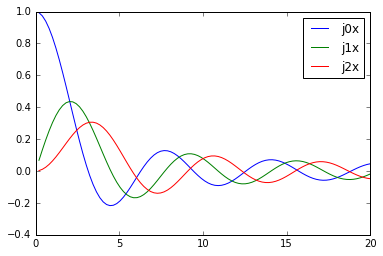

In [48]:
%matplotlib inline
from a212libs.bessel_fun import bessel
import numpy as np
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 20, 100)
for order in [0, 1, 2]:
    ax.plot(x, bessel(x, order), label='j{}x'.format(order))
ax.legend()

In [46]:
import a212libs.bessel_fun
from importlib import reload
reload(a212libs.bessel_fun)
from a212libs.bessel_fun import test_bessel
test_bessel()

### 2\. dice

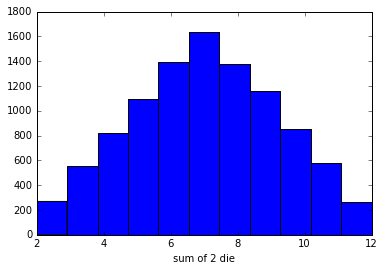

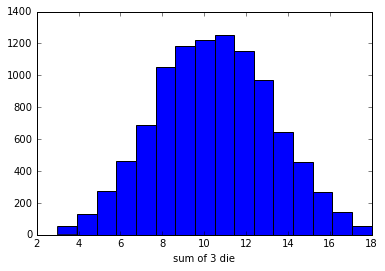

In [16]:
import numpy.random as random
from matplotlib import pyplot as plt

#
# set the seed so we get the same result each time we run
#
random.seed(100)

def sum_dice(ndice=2,nrolls=10000):
    the_rolls=[]
    for i in range(nrolls):
        sum=0
        for dice in range(ndice):
            sum=sum + random.random_integers(1,6)
        the_rolls.append(sum)
    return the_rolls

rolls = sum_dice()
fig,ax = plt.subplots(1,1)
ax.hist(rolls,bins=11)
ax.set(xlabel = 'sum of 2 die')

rolls = sum_dice(ndice=3)
fig,ax = plt.subplots(1,1)
out = ax.hist(rolls,bins=16)
out=ax.set(xlabel = 'sum of 3 die')







### 4\.  LineFitWt(x, y, dy)

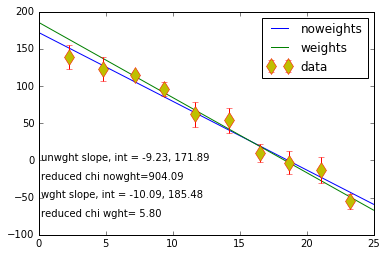

In [44]:
plt.close('all')
from a212libs.utils import read_data

def LineFit(x, y):
    ''' Returns slope and y-intercept of linear fit to (x,y)
    data set'''
    xavg = x.mean()
    slope = (y*(x-xavg)).sum()/(x*(x-xavg)).sum()
    yint = y.mean()-slope*xavg
    return slope, yint

def LineFitWt(x, y, dy):
    dy2 = dy**2.
    denom= np.sum(1/(dy**2.))  # Pine 7.14
    xnumerator = np.sum(x/dy2)
    ynumerator = np.sum(y/dy2)
    xhat = xnumerator/denom
    yhat = ynumerator/denom
    bnum = np.sum((x - xhat)*y/dy2)
    bdenom = np.sum((x - xhat)*x/dy2)
    slope = bnum/bdenom
    yint = yhat - slope*xhat
    return slope,yint

def reduced_chi(x,y,slope,intercept,dy=None):
    """
      pine 7.11 -- if dy is missing, set sigma_i=1
    """
    if dy is None:
        dy = np.ones_like(x)
    f_x = intercept + slope*x
    chisquare = np.sum((((y - f_x)/dy))**2.)
    return chisquare

data_string = """
time   velocity   uncertainty
  2.23          139               16
  4.78          123               16
  7.21          115                4
  9.37           96                9
 11.64           62               17
 14.23           54               17
 16.55           10               12
 18.70           -3               15
 21.05          -13               18
 23.21          -55               10
"""
df_data = read_data(data_string)
time = df_data['time'].values
velocity = df_data['velocity'].values
dy = df_data['uncertainty'].values

fig,ax = plt.subplots(1,1)
out=ax.errorbar('time','velocity',yerr='uncertainty',data=df_data,
                fmt='bo',ecolor='r',marker='d',mec='r',mfc='y',ms=12,zorder=10,
               label='data')
limits=ax.axis()
slope_nw,yint_nw = LineFit(time,velocity)
xvals=np.array(limits[:2])
yvals = yint_nw + slope_nw*xvals
chir_nw = reduced_chi(time,velocity,slope_nw,yint_nw)
ax.plot(xvals,yvals,'b-',label = 'noweights')
ax.text(0.2,0,'unwght slope, int = {:5.2f}, {:5.2f}'.format(slope_nw,yint_nw))
ax.text(0.2,-25,'reduced chi nowght={:5.2f}'.format(chir_nw))
slope_w,yint_w = LineFitWt(time,velocity,dy)
chir_w = reduced_chi(time,velocity,slope_w,yint_w,dy=dy)
yvals = yint_w + slope_w*xvals
ax.plot(xvals,yvals,'g-',label = 'weights')
ax.text(0.2,-50,'wght slope, int = {:5.2f}, {:5.2f}'.format(slope_w,yint_w))
ax.text(0.2,-75,'reduced chi wght={:5.2f}'.format(chir_w))
out=ax.legend()
